In [559]:
import numpy
import math
from numpy import arange
import csv
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
from torch.utils.mobile_optimizer import optimize_for_mobile

In [560]:
#First section creates the CSV data, from a basic mathematical function with 3 independent variables

In [561]:
def getY(i, j, k):
    return  i ** 2 + 3*j + math.sqrt(k)

In [562]:
def testGetY():
    result = getY(1, 1, 1)
    assert(result == 5)
    result = getY(2, 2, 4)
    assert(result == 12)

In [563]:
testGetY()

In [564]:
# Creates data set within range of 0 to 5 for all inputs
def createData():
    list = []
    for i in arange(0.0, 5.0, 0.1):
        for j in arange(0.0, 5.0, 0.1):
            for k in arange(0.0, 5.0, 0.1):
               result = getY(i, j, k)
               roundResult = round(result, 2)
               list.append([round(i, 1), round(j, 1), round(k, 1), roundResult])
    return list

In [565]:
def createCSVFromData(listInput):
    with open('mathData.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['i','j','k','y'])
        for i in listInput:
            filewriter.writerow(i)

In [566]:
list = createData()
createCSVFromData(list)

In [567]:
#Second section does the ML for the data

dls = TabularDataLoaders.from_csv('mathData.csv', y_names='y',
    cont_names = ['i', 'j', 'k'],
    procs = None)

learn = tabular_learner(dls, metrics=[rmse])

In [568]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=3, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

SuggestedLRs(valley=0.005248074419796467)

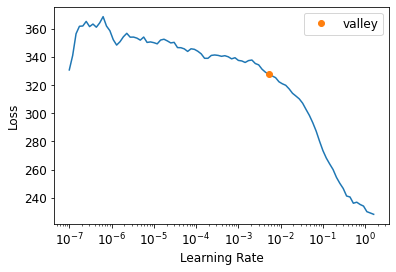

In [569]:
# Find the optimal learning rate.
learn.lr_find()

In [570]:
# Train model, using the 1 cycle policy, which varies the learning rate optimally.
learn.fit_one_cycle(3, 0.011)

epoch,train_loss,valid_loss,_rmse,time
0,1.746988,0.372215,0.610094,00:13
1,1.755982,0.108018,0.328661,00:13
2,1.298894,0.139628,0.373668,00:14


In [571]:
#Run a test case. 
# "Cont" means continous data, vs categorical.
contInputData = {'i': [2.1],
	'j': [4.2],
	'k': [4.3]}

contInputDf = pd.DataFrame(contInputData)

print("Input for a test case:")
contInputVal = contInputDf.iloc[0]
print(contInputVal)

i1 = contInputVal['i']
j1 = contInputVal['j']
k1 = contInputVal['k']

result = getY(i1, j1, k1)
print("True calculated result:")
print(round(result, 2))

print("ML prediction:")
row, clas, probs = learn.predict(contInputVal)
row.show()

Input for a test case:
i    2.1
j    4.2
k    4.3
Name: 0, dtype: float64
True calculated result:
19.08
ML prediction:


,i,j,k,y
0,2.1,4.2,4.3,19.140711


In [572]:
# Check prediction using the PyTorch model, not FastAI predict.
with torch.no_grad():
    finalModel = learn.model.eval().to("cpu")
    cont_example_input = torch.tensor(contInputDf.values).to("cpu").float()
    cat_example_input = torch.tensor([])
    print("Pytorch prediction:")
    output = finalModel(cat_example_input, cont_example_input)

Pytorch prediction:


In [573]:
output

tensor([[19.1407]])

In [574]:
# Deploy model to tensor lite for mobile
# There is no category input data, only continous. So we set it blank.
catExamp = torch.tensor([])
# The input for categorical and continuous data combined is a tuple
example_input = (catExamp, torch_tensor)
traced_script_module = torch.jit.trace(finalModel, example_input)

In [575]:
optimized_traced_model = optimize_for_mobile(traced_script_module)
optimized_traced_model._save_for_lite_interpreter("model.ptl")